KPIs comparativos (g):


C:\Users\alvar\AppData\Local\Temp\ipykernel_30044\2015577417.py:70: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)
C:\Users\alvar\AppData\Local\Temp\ipykernel_30044\2015577417.py:70: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)


,feeder,mac,sampling_s_median,total_consumo_g,total_refill_g,n_refill_events,avg_refill_g
0,ls1,40:22:D8:F1:E3:70,1802.0,245350.532264,258356.725850,20,10518.052204
1,ls5,B8:D6:1A:60:94:1C,1802.0,228032.502761,238918.121306,20,8326.791328


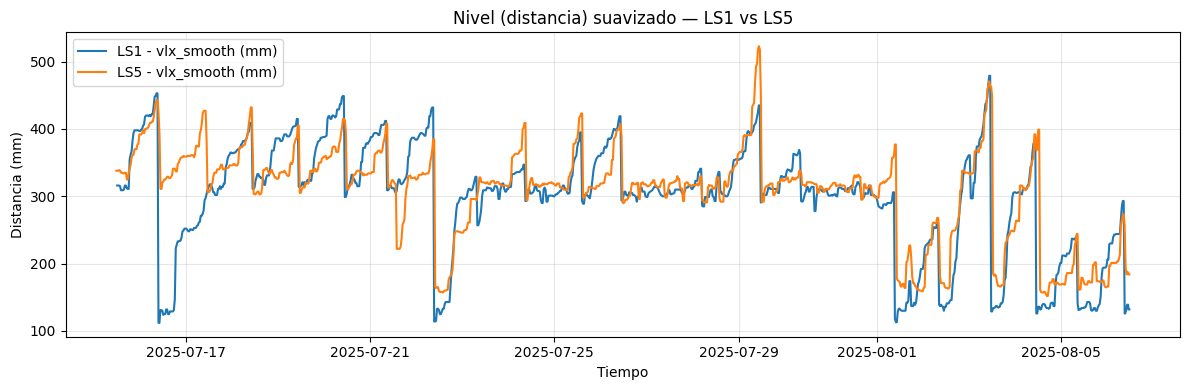

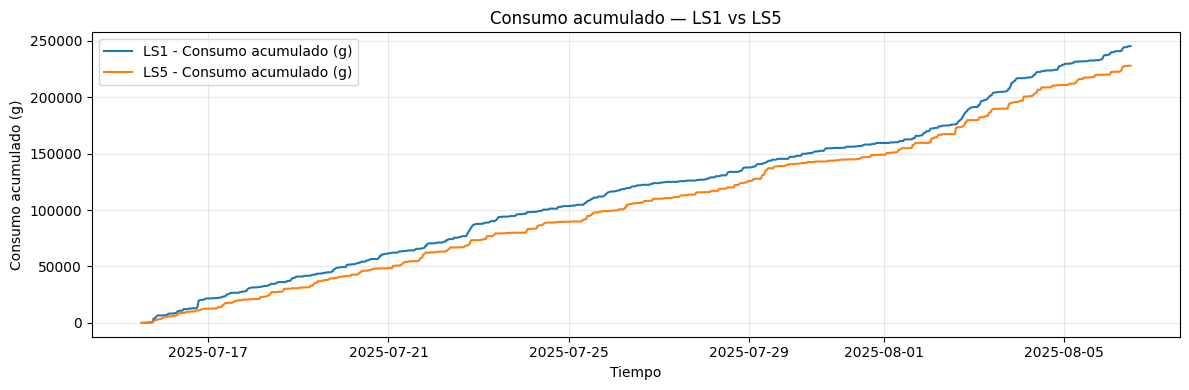

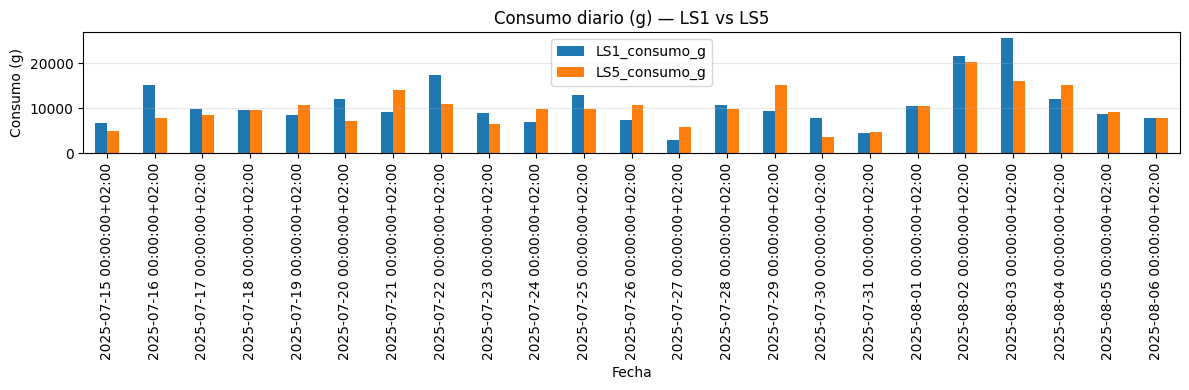

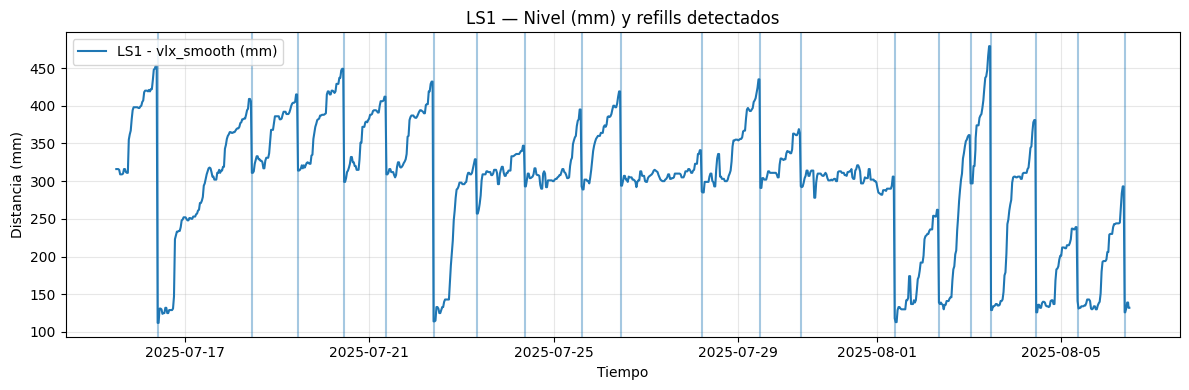

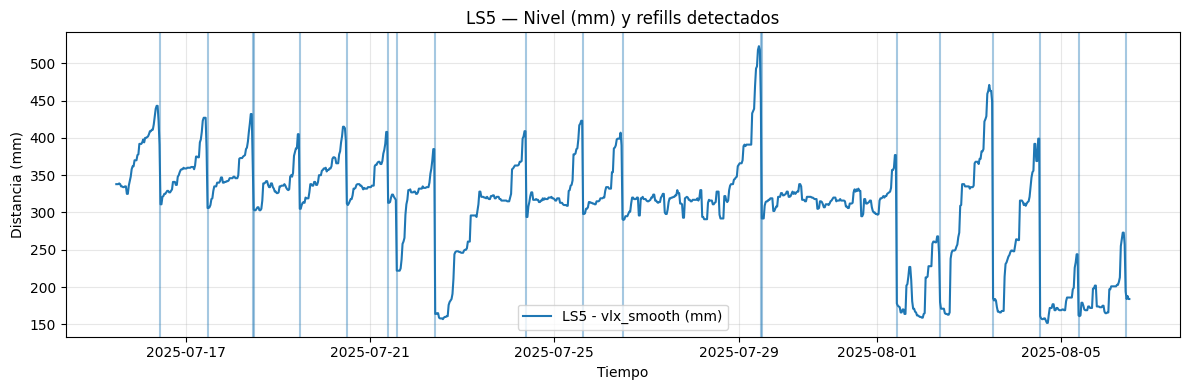

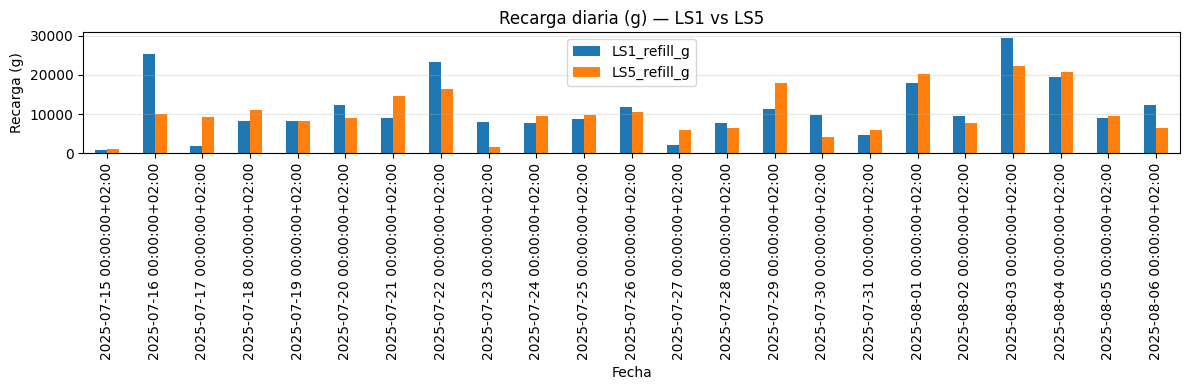


--- RESUMEN EJECUTIVO ---
LS1 -> Consumo total: 245,351 g | Media diaria: 10,667 g/día | Refills: 20 (media 10,518 g por refill) | Recarga total: 258,357 g
LS5 -> Consumo total: 228,033 g | Media diaria: 9,914 g/día | Refills: 20 (media 8,327 g por refill) | Recarga total: 238,918 g

Artefactos guardados en: D:\ls_feed\data_drive\_compare_ls1_ls5
 - ts_vlx_smooth_ls1_vs_ls5.png
 - cum_consumo_g_ls1_vs_ls5.png
 - bar_consumo_diario_g_ls1_vs_ls5.png
 - ls1_vlx_refills.png, ls5_vlx_refills.png
 - kpis_ls1_ls5.csv, refill_events_*.csv, *_enriched.parquet


In [1]:
# %% COMPARATIVA PROFESIONAL LS1 vs LS5: consumo, refills y visualización
# Requisitos: pandas, numpy, matplotlib
# Entrada esperada: data_drive/_parquet_export/split/ls1.parquet y ls5.parquet
# Columnas: mac (str), time (str/num datetime), vlx (mm), source_file (str opcional)
#
# Hipótesis geométricas (proporcionadas):
# - Recipiente circular, diámetro = 30 cm -> radio = 15 cm
# - 200 g ≈ 200 ml  => densidad aproximada ~ 1 g/ml
# Conversión:
#   Δh (mm) -> Δh_cm = Δh_mm / 10
#   Volumen (ml) = Área_base_cm2 * Δh_cm
#   Masa (g) ≈ Volumen (ml)
#
# Notas de interpretación:
# - Sensor sobre el pienso: distancias MENORES => más pienso; distancias MAYORES => menos pienso.
# - Consumo proxy = SUMA de incrementos positivos de distancia (Δvlx_mm > 0).
# - Refill proxy = eventos con saltos negativos grandes en distancia (Δvlx_mm << 0).
# - Las magnitudes se dan en ml/g usando el área del comedero. Sin calibración adicional, son aproximaciones.
# - Todos los gráficos se hacen con matplotlib (una figura por gráfico, sin estilos específicos).

from __future__ import annotations

import math
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- CONFIGURACIÓN ---------------------------

IN_DIR = Path("data_drive/_parquet_export/split")
OUT_DIR = Path("data_drive/_compare_ls1_ls5")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TIMEZONE = "Europe/Madrid"
ASSUME_LOCALTIME = True

# Geometría del comedero
DIAM_CM = 30.0
R_CM = DIAM_CM / 2.0
AREA_CM2 = math.pi * (R_CM ** 2)     # ~706.86 cm^2
DENS_G_PER_ML = 1.0                  # 200 g ≈ 200 ml

# Suavizado / umbrales
ROLL_MED_MINUTES = 2.0        # ventana de mediana rodante por puntos, adaptada al muestreo
Hampel_Window_Minutes = 3.0   # ventana hampel en minutos
Hampel_k = 3.0
REFILL_MIN_SEP_MIN = 10.0     # separación mínima entre recargas
BIMODAL_USE_OTSU = True       # umbral alternativo si hay bimodalidad
MIN_POINTS_SMOOTH = 3         # mínimo de puntos para rolling

# Detección refills: si None, umbral auto por distribución de diferencias
REFILL_JUMP_MM = None

# --------------------------- UTILIDADES ---------------------------

def parse_time_series(s: pd.Series) -> pd.Series:
    """Parseo robusto de 'time' -> datetime con TZ Europe/Madrid si ASSUME_LOCALTIME=True."""
    if pd.api.types.is_numeric_dtype(s):
        m = s.median()
        if m > 1e12:
            dt = pd.to_datetime(s, unit="ms", errors="coerce")
        elif m > 1e9:
            dt = pd.to_datetime(s, unit="s", errors="coerce")
        else:
            dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    else:
        dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)

    if ASSUME_LOCALTIME:
        if dt.dt.tz is None:
            dt = dt.dt.tz_localize(TIMEZONE, nonexistent="NaT", ambiguous="NaT")
        else:
            dt = dt.dt.tz_convert(TIMEZONE)
    return dt

def estimate_sampling_seconds(t: pd.Series) -> float:
    dt = t.sort_values().diff().dropna().dt.total_seconds()
    if dt.empty:
        return 1.0
    return float(dt.median())

def minutes_to_points(minutes: float, sampling_s: float) -> int:
    return max(1, int(round((minutes * 60.0) / max(0.5, sampling_s))))

def hampel_filter(x: pd.Series, window_points: int, k: float = 3.0) -> pd.Series:
    """Hampel robusto (mediana +- k * 1.4826*MAD) con ventana mínima garantizada."""
    w = max(MIN_POINTS_SMOOTH, int(window_points))
    med = x.rolling(w, center=True, min_periods=w).median()
    mad = (x - med).abs().rolling(w, center=True, min_periods=w).median()
    sigma = 1.4826 * mad
    outliers = (x - med).abs() > (k * sigma)
    return x.where(~outliers, med).astype(float)

def otsu_threshold(values: np.ndarray, nbins: int = 256) -> Optional[float]:
    """Umbral de Otsu (si hay bimodalidad clara)."""
    v = values[np.isfinite(values)]
    if v.size < 10 or np.nanstd(v) < 1e-9:
        return None
    hist, bin_edges = np.histogram(v, bins=nbins)
    weight1 = np.cumsum(hist)
    weight2 = v.size - weight1
    means = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean1 = np.cumsum(hist * means)
    mean2 = mean1[-1] - mean1
    valid = (weight1 > 0) & (weight2 > 0)
    if not valid.any():
        return None
    var12 = ((mean1[valid] / weight1[valid]) - (mean2[valid] / weight2[valid])) ** 2 * (weight1[valid] * weight2[valid])
    idx = np.argmax(var12)
    return float(means[np.where(valid)[0][idx]])

def ensure_columns(df: pd.DataFrame, required=("mac","time","vlx")):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {missing}. Presentes: {df.columns.tolist()}")

def mm_to_ml(delta_mm: np.ndarray | pd.Series) -> np.ndarray:
    """Δmm -> ml usando el área del comedero."""
    delta_cm = np.asarray(delta_mm, dtype=float) / 10.0
    return AREA_CM2 * delta_cm

def ml_to_g(ml: np.ndarray | pd.Series) -> np.ndarray:
    return np.asarray(ml, dtype=float) * DENS_G_PER_ML

def compute_diffs_and_flows(df: pd.DataFrame) -> pd.DataFrame:
    """
    A partir de 'vlx_smooth' calcula:
    - diff_mm: diferencia primera derivada
    - consumo_mm: solo incrementos positivos (aumenta distancia -> baja nivel)
    - refill_mm: solo decrementos (saltos negativos)
    - consumo_ml/g y refill_ml/g
    """
    s = df["vlx_smooth"].copy()
    # Rellenar bordes del suavizado para evitar NaNs iniciales/finales
    s = s.ffill().bfill()
    diff_mm = s.diff()
    consumo_mm = diff_mm.clip(lower=0.0)          # consumo (proxy)
    refill_mm = (-diff_mm.clip(upper=0.0))        # recargas como magnitud positiva

    consumo_ml = mm_to_ml(consumo_mm)
    refill_ml = mm_to_ml(refill_mm)
    consumo_g = ml_to_g(consumo_ml)
    refill_g = ml_to_g(refill_ml)

    df2 = df.copy()
    df2["diff_mm"] = diff_mm
    df2["consumo_mm"] = consumo_mm
    df2["refill_mm"] = refill_mm
    df2["consumo_ml"] = consumo_ml
    df2["refill_ml"] = refill_ml
    df2["consumo_g"] = consumo_g
    df2["refill_g"] = refill_g
    return df2

'''def detect_refills(df: pd.DataFrame, sampling_s: float) -> pd.DataFrame:
    """
    Eventos discretos de refill a partir de saltos negativos significativos en 'vlx_smooth'.
    Retorna DataFrame con columnas: time, jump_mm, jump_ml, jump_g
    """
    d = df["vlx_smooth"].diff()
    neg = d.dropna()[d.dropna() < 0.0]
    if REFILL_JUMP_MM is None:
        if len(neg) == 0:
            thr = -np.inf
        else:
            # umbral robusto: más negativo que p1 o -5*std (elige el más conservador)
            thr = min(neg.quantile(0.01), -5.0 * float(d.std() or 0.0))
            thr = min(thr, - np.nanpercentile(abs(d.values), 75))
    else:
        thr = -abs(REFILL_JUMP_MM)

    candidates = d[d <= thr]
    if candidates.empty:
        return pd.DataFrame(columns=["time", "jump_mm", "jump_ml", "jump_g"])

    # anti-duplicado temporal
    min_sep_pts = minutes_to_points(REFILL_MIN_SEP_MIN, sampling_s)
    idx = candidates.index
    keep = []
    last = None
    for i in idx:
        if last is None or (i - last) >= min_sep_pts:
            keep.append(i)
            last = i

    jumps_mm = d.loc[keep].values
    jumps_ml = mm_to_ml(-jumps_mm)    # magnitud positiva
    jumps_g  = ml_to_g(jumps_ml)
    events = pd.DataFrame({
        "time": df.loc[keep, "time"].values,
        "jump_mm": -jumps_mm,         # positiva = cantidad recargada en mm
        "jump_ml":  jumps_ml,
        "jump_g":   jumps_g
    })
    return events'''
    
def detect_refills(df: pd.DataFrame, sampling_s: float) -> pd.DataFrame:
    """
    Detecta eventos de refill como una bajada en 'vlx_smooth' SUPERIOR a 50 mm (5 cm).
    Devuelve DataFrame con columnas: time, jump_mm, jump_ml, jump_g
    """
    d = df["vlx_smooth"].diff()

    # CAMBIO AQUÍ: cualquier bajada superior a 50mm (5 cm)
    threshold_mm = -50.0
    candidates = d[d < threshold_mm]
    
    if candidates.empty:
        return pd.DataFrame(columns=["time", "jump_mm", "jump_ml", "jump_g"])

    # anti-duplicado temporal (mínima separación entre refills)
    min_sep_pts = minutes_to_points(REFILL_MIN_SEP_MIN, sampling_s)
    keep, last = [], None
    for i in candidates.index:
        if last is None or (i - last) >= min_sep_pts:
            keep.append(i)
            last = i

    # magnitudes positivas
    jumps_mm = -d.loc[keep].values
    jumps_ml = mm_to_ml(jumps_mm)
    jumps_g  = ml_to_g(jumps_ml)

    events = pd.DataFrame({
        "time": df.loc[keep, "time"].values,
        "jump_mm": jumps_mm,
        "jump_ml":  jumps_ml,
        "jump_g":   jumps_g
    })
    return events


def prepare_df(parquet_path: Path) -> Tuple[pd.DataFrame, pd.Series, float]:
    """
    Carga, tipifica, filtra outliers con Hampel y suaviza (mediana rodante).
    Devuelve (df, mac, sampling_s).
    df contiene: time, mac, vlx_mm, vlx_filt, vlx_smooth
    """
    df = pd.read_parquet(parquet_path)
    ensure_columns(df, ("mac","time","vlx"))

    df = df[["mac","time","vlx"] + ([c for c in df.columns if c == "source_file"])]
    df["mac"] = df["mac"].astype("string").str.strip()
    df["time"] = parse_time_series(df["time"])
    df["vlx_mm"] = pd.to_numeric(df["vlx"], errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time").drop_duplicates(subset=["time"], keep="last")
    mac_mode = df["mac"].mode().iloc[0] if not df["mac"].isna().all() else pd.NA

    if len(df) < 3:
        raise ValueError(f"Datos insuficientes en {parquet_path.name} para suavizado.")

    sampling_s = estimate_sampling_seconds(df["time"])
    w_hampel = minutes_to_points(Hampel_Window_Minutes, sampling_s)
    w_hampel = max(MIN_POINTS_SMOOTH, w_hampel)
    df["vlx_filt"] = hampel_filter(df["vlx_mm"], window_points=w_hampel, k=Hampel_k)

    w_med = minutes_to_points(ROLL_MED_MINUTES, sampling_s)
    w_med = max(MIN_POINTS_SMOOTH, w_med)
    df["vlx_smooth"] = df["vlx_filt"].rolling(w_med, center=True, min_periods=w_med).median()
    # rellena bordes del suavizado
    df["vlx_smooth"] = df["vlx_smooth"].ffill().bfill()

    return df[["time","mac","vlx_mm","vlx_filt","vlx_smooth"]], mac_mode, sampling_s

def aggregate_daily(df: pd.DataFrame) -> pd.DataFrame:
    """Agrega consumo/refill por día (suma de incrementos/recargas)."""
    tmp = df.set_index("time")
    daily = pd.DataFrame()
    daily["consumo_g"] = tmp["consumo_g"].resample("1D").sum(min_count=1)
    daily["refill_g"]  = tmp["refill_g"].resample("1D").sum(min_count=1)
    daily["consumo_ml"] = tmp["consumo_ml"].resample("1D").sum(min_count=1)
    daily["refill_ml"]  = tmp["refill_ml"].resample("1D").sum(min_count=1)
    daily["n_points"]   = tmp["vlx_mm"].resample("1D").size()
    return daily

# --------------------------- CARGA Y PREPARACIÓN ---------------------------

p_ls1 = IN_DIR / "ls1.parquet"
p_ls5 = IN_DIR / "ls5.parquet"
if not p_ls1.exists() or not p_ls5.exists():
    raise SystemExit(f"Faltan ls1.parquet o ls5.parquet en {IN_DIR.resolve()}")

df1_raw, mac1, samp1 = prepare_df(p_ls1)
df5_raw, mac5, samp5 = prepare_df(p_ls5)

# Diffs y flujos (consumo/refill)
df1 = compute_diffs_and_flows(df1_raw)
df5 = compute_diffs_and_flows(df5_raw)

# Eventos discretos de refill
refills1 = detect_refills(df1, samp1)
refills5 = detect_refills(df5, samp5)

# Agregados diarios
d1 = aggregate_daily(df1)
d5 = aggregate_daily(df5)

# KPIs
kpis = pd.DataFrame({
    "feeder": ["ls1","ls5"],
    "mac": [str(mac1), str(mac5)],
    "sampling_s_median": [samp1, samp5],
    "total_consumo_g": [float(df1["consumo_g"].sum()), float(df5["consumo_g"].sum())],
    "total_refill_g": [float(df1["refill_g"].sum()), float(df5["refill_g"].sum())],
    "n_refill_events": [int(len(refills1)), int(len(refills5))],
    "avg_refill_g": [
        float(refills1["jump_g"].mean()) if len(refills1)>0 else 0.0,
        float(refills5["jump_g"].mean()) if len(refills5)>0 else 0.0,
    ],
})
kpis_path = OUT_DIR / "kpis_ls1_ls5.csv"
kpis.to_csv(kpis_path, index=False)

print("KPIs comparativos (g):")
display(kpis)

# --------------------------- VISUALIZACIONES ---------------------------
# Reglas: una figura por gráfico, sin estilos explícitos.

# 1) Serie temporal de nivel (vlx_smooth) para ambos comederos
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["vlx_smooth"], label="LS1 - vlx_smooth (mm)")
plt.plot(df5["time"], df5["vlx_smooth"], label="LS5 - vlx_smooth (mm)")
plt.title("Nivel (distancia) suavizado — LS1 vs LS5")
plt.xlabel("Tiempo")
plt.ylabel("Distancia (mm)")
plt.grid(True, alpha=0.3)
plt.legend()
fig.tight_layout()
plt.show()

# 2) Consumo acumulado (g) comparativo
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["consumo_g"].cumsum(), label="LS1 - Consumo acumulado (g)")
plt.plot(df5["time"], df5["consumo_g"].cumsum(), label="LS5 - Consumo acumulado (g)")
plt.title("Consumo acumulado — LS1 vs LS5")
plt.xlabel("Tiempo")
plt.ylabel("Consumo acumulado (g)")
plt.grid(True, alpha=0.3)
plt.legend()
fig.tight_layout()
plt.show()

# 3) Barras por día: consumo (g) de LS1 vs LS5
d_join = pd.DataFrame({
    "LS1_consumo_g": d1["consumo_g"],
    "LS5_consumo_g": d5["consumo_g"],
}).sort_index()
fig = plt.figure(figsize=(12, 4))
d_join.plot(kind="bar", ax=plt.gca())
plt.title("Consumo diario (g) — LS1 vs LS5")
plt.xlabel("Fecha")
plt.ylabel("Consumo (g)")
plt.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

# 4) Serie temporal por feeder con refills anotados (LS1)
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["vlx_smooth"], label="LS1 - vlx_smooth (mm)")
if len(refills1) > 0:
    for _, r in refills1.iterrows():
        plt.axvline(pd.to_datetime(r["time"]), alpha=0.4)
plt.title("LS1 — Nivel (mm) y refills detectados")
plt.xlabel("Tiempo")
plt.ylabel("Distancia (mm)")
plt.grid(True, alpha=0.3)
plt.legend()
fig.tight_layout()
plt.show()

# 5) Serie temporal por feeder con refills anotados (LS5)
fig = plt.figure(figsize=(12, 4))
plt.plot(df5["time"], df5["vlx_smooth"], label="LS5 - vlx_smooth (mm)")
if len(refills5) > 0:
    for _, r in refills5.iterrows():
        plt.axvline(pd.to_datetime(r["time"]), alpha=0.4)
plt.title("LS5 — Nivel (mm) y refills detectados")
plt.xlabel("Tiempo")
plt.ylabel("Distancia (mm)")
plt.grid(True, alpha=0.3)
plt.legend()
fig.tight_layout()
plt.show()

# 6) Barras por día: refill (g) LS1 vs LS5
d_ref = pd.DataFrame({
    "LS1_refill_g": d1["refill_g"],
    "LS5_refill_g": d5["refill_g"],
}).sort_index()
fig = plt.figure(figsize=(12, 4))
d_ref.plot(kind="bar", ax=plt.gca())
plt.title("Recarga diaria (g) — LS1 vs LS5")
plt.xlabel("Fecha")
plt.ylabel("Recarga (g)")
plt.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

# --------------------------- INFORMES Y EXPORT ---------------------------

# Guardar refills detectados con magnitud (g/ml/mm)
refills1.to_csv(OUT_DIR / "refill_events_ls1.csv", index=False)
refills5.to_csv(OUT_DIR / "refill_events_ls5.csv", index=False)

# Guardar consumo diario comparado
d_join.to_csv(OUT_DIR / "consumo_diario_g_ls1_vs_ls5.csv", index=True)
d_ref.to_csv(OUT_DIR / "refill_diario_g_ls1_vs_ls5.csv", index=True)

# Resumen ejecutivo en texto
def resumen_texto(nombre: str, df: pd.DataFrame, d: pd.DataFrame, ref: pd.DataFrame) -> str:
    total_g = float(df["consumo_g"].sum())
    total_refill_g = float(df["refill_g"].sum())
    dias = int(d.shape[0])
    media_dia = (total_g / dias) if dias > 0 else np.nan
    n_ref = int(len(ref))
    avg_ref = float(ref["jump_g"].mean()) if n_ref > 0 else 0.0
    return (
        f"{nombre} -> Consumo total: {total_g:,.0f} g | Media diaria: {media_dia:,.0f} g/día | "
        f"Refills: {n_ref} (media {avg_ref:,.0f} g por refill) | Recarga total: {total_refill_g:,.0f} g"
    )

print("\n--- RESUMEN EJECUTIVO ---")
print(resumen_texto("LS1", df1, d1, refills1))
print(resumen_texto("LS5", df5, d5, refills5))

# Guardar series enriquecidas (opcional, útil para reproducibilidad/BI)
df1.to_parquet(OUT_DIR / "ls1_enriched.parquet", index=False)
df5.to_parquet(OUT_DIR / "ls5_enriched.parquet", index=False)

print(f"\nArtefactos guardados en: {OUT_DIR.resolve()}")
print(" - ts_vlx_smooth_ls1_vs_ls5.png")
print(" - cum_consumo_g_ls1_vs_ls5.png")
print(" - bar_consumo_diario_g_ls1_vs_ls5.png")
print(" - ls1_vlx_refills.png, ls5_vlx_refills.png")
print(" - kpis_ls1_ls5.csv, refill_events_*.csv, *_enriched.parquet")


C:\Users\alvar\AppData\Local\Temp\ipykernel_30044\3334191287.py:63: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)
C:\Users\alvar\AppData\Local\Temp\ipykernel_30044\3334191287.py:63: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)


## KPIs comparativos (LS1 vs LS5)

Valores agregados de consumo y recarga. El consumo se aproxima mediante incrementos de distancia (mm→ml→g) y las recargas como descensos.

,feeder,mac,sampling_s_median,total_consumo_g,total_refill_g,n_refill_events,avg_refill_g
0,LS1,40:22:D8:F1:E3:70,1802.0,245350.532264,258356.725850,20,10518.052204
1,LS5,B8:D6:1A:60:94:1C,1802.0,228032.502761,238918.121306,20,8326.791328


## Contraste de consumo diario

- **Mann–Whitney U** (no paramétrico) y **Welch t-test** (paramétrico) sobre consumo diario.

Mann–Whitney U (consumo diario): MannwhitneyuResult(statistic=np.float64(270.5), pvalue=np.float64(0.9038016787773692))
Welch t-test (consumo diario): TtestResult(statistic=np.float64(0.5535935123577312), pvalue=np.float64(0.5828235352811059), df=np.float64(41.55725751413664))
Ambos tests coinciden: no se detectan diferencias significativas en el consumo diario entre LS1 y LS5. En otras palabras: estadísticamente, los dos comederos se comportan igual en cuanto al consumo diario en el período analizado.


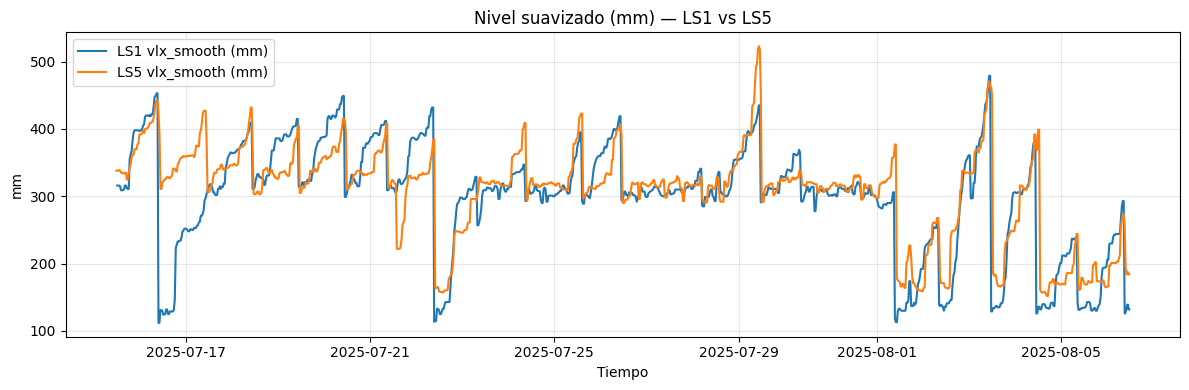

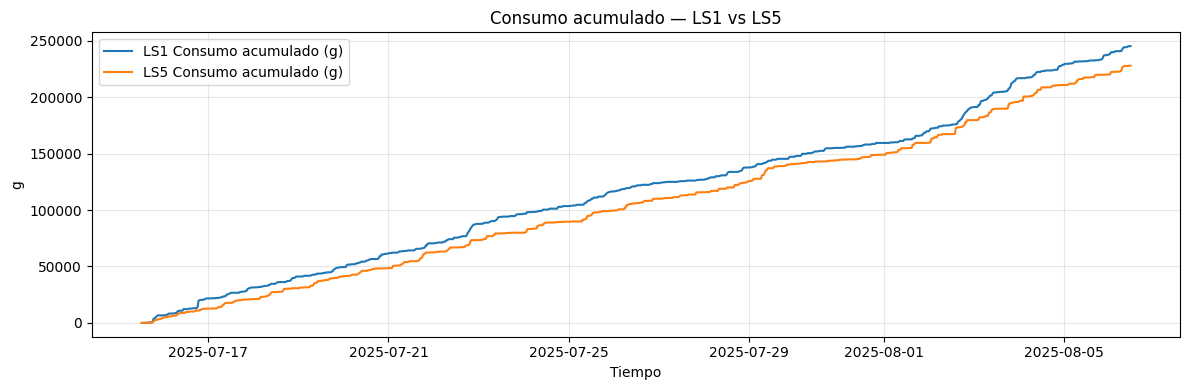

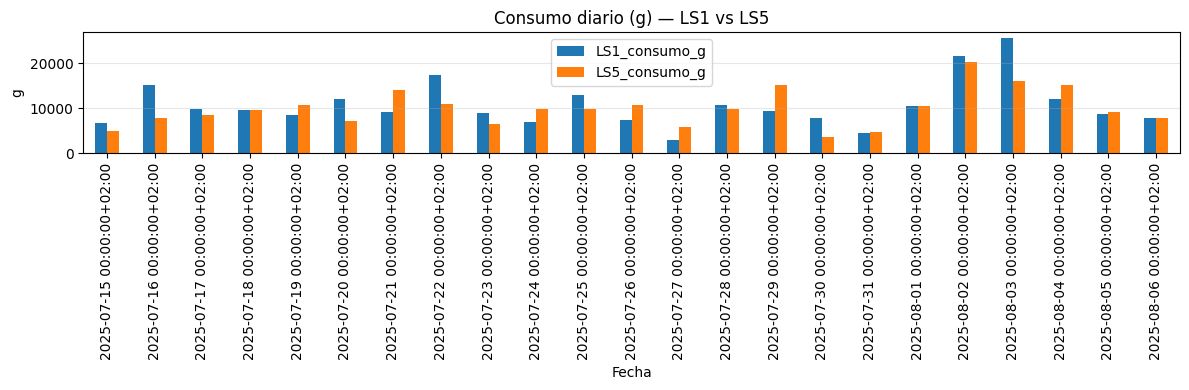

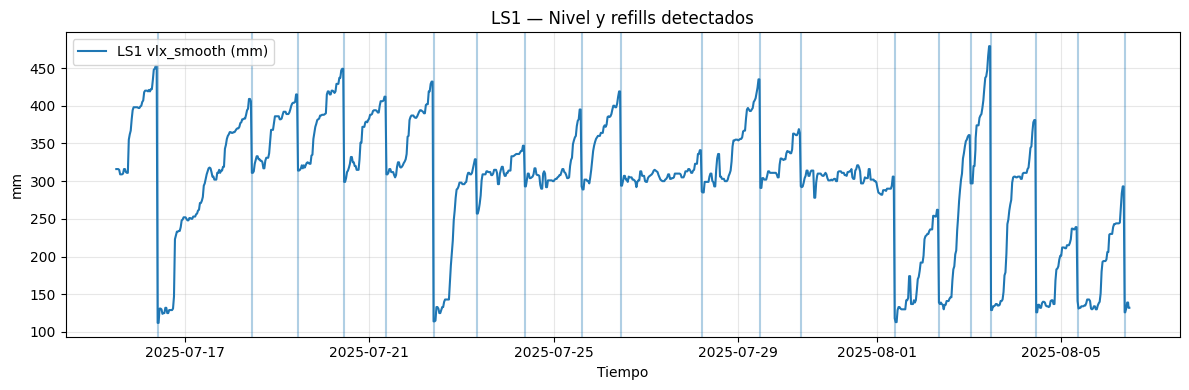

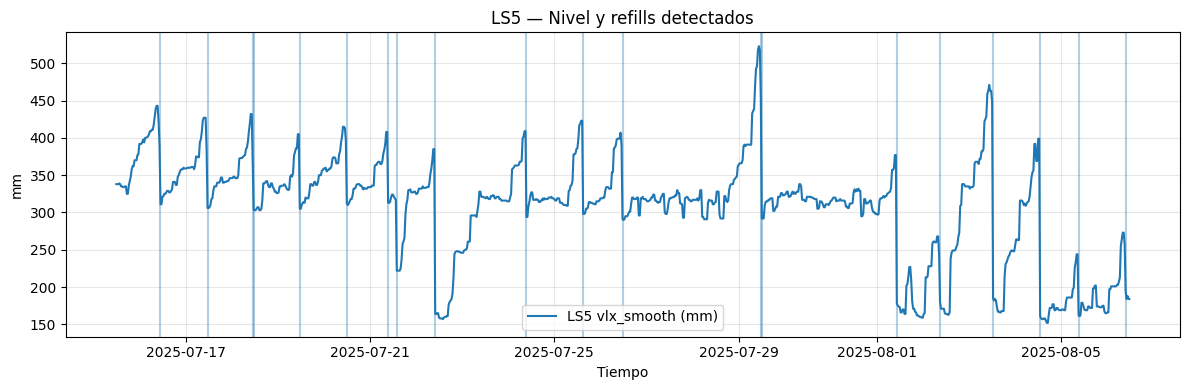

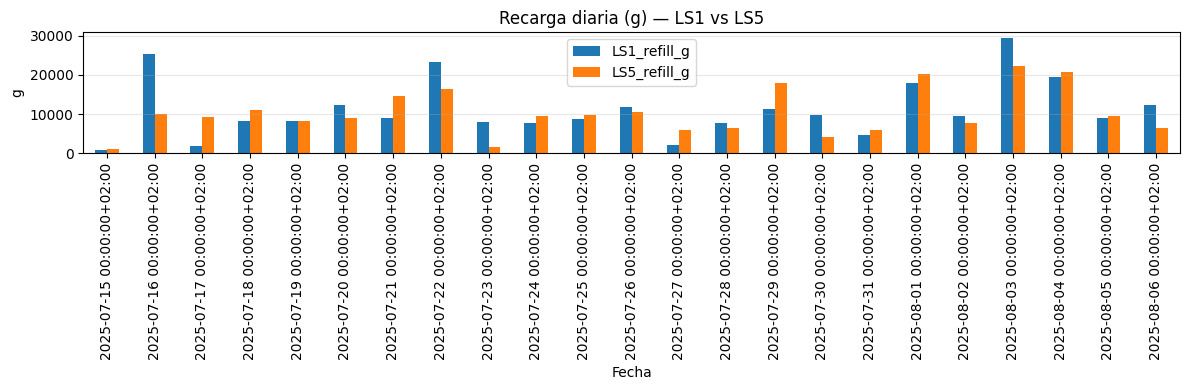

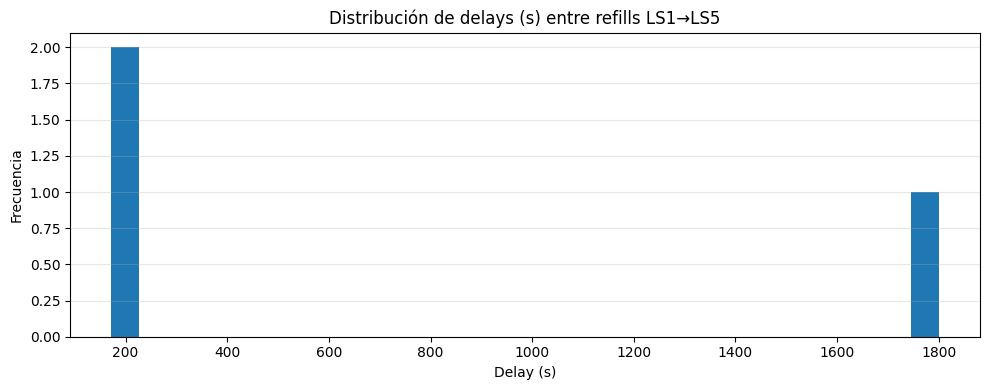

,t_ls1,t_ls5,delay_s,jump_g_ls1,jump_g_ls5,ratio_g
0,2025-07-18 08:48:00,2025-07-18 08:50:54,174.0,6715.154297,4453.207586,0.663158
1,2025-07-29 09:31:43,2025-07-29 09:34:35,172.0,10178.760198,4594.579256,0.451389
2,2025-08-06 07:08:02,2025-08-06 07:38:02,1800.0,11804.534396,4453.207586,0.377246


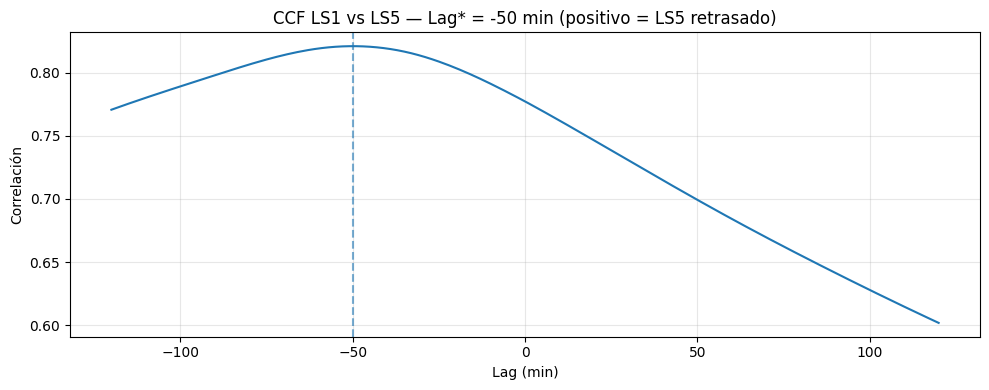

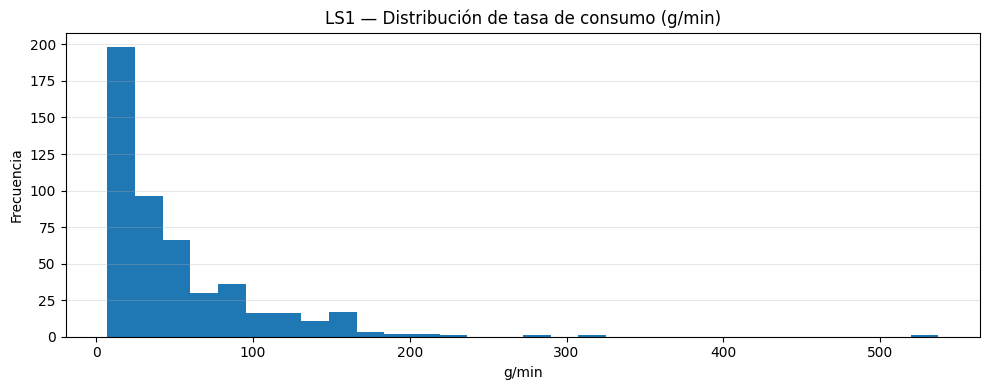

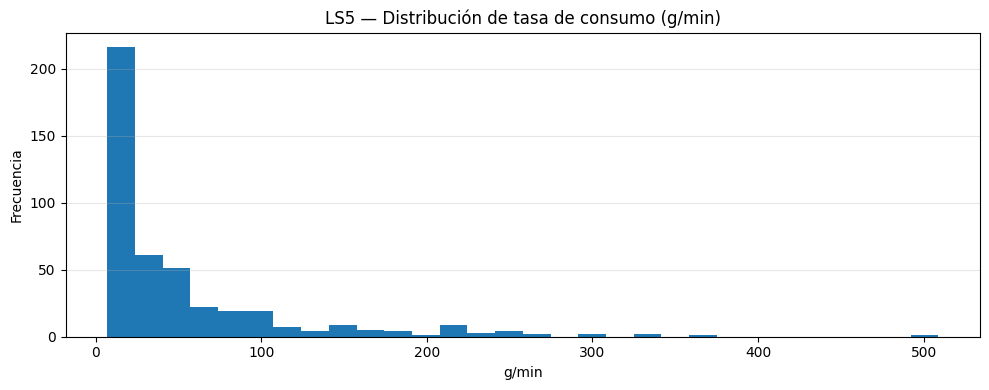


--- RESUMEN EJECUTIVO ---
LS1 -> Consumo total: 245,351 g | Media diaria: 10,667 g/día | Refills: 20 (media 10,518 g) | Recarga total: 258,357 g
LS5 -> Consumo total: 228,033 g | Media diaria: 9,914 g/día | Refills: 20 (media 8,327 g) | Recarga total: 238,918 g
Delay mediano LS1→LS5: 174.0 s | Ratio mediana (LS5/LS1) en jump_g: 0.45

Artefactos guardados en: D:\ls_feed\data_drive\_compare_ls1_ls5


In [2]:
# %% COMPARATIVA INTEGRAL — LS1 vs LS5 (refills = TODA bajada de nivel) + GRÁFICOS EXPLICADOS
# Esta celda es AUTOCONTENIDA y lista para ejecutarse justo a continuación.
# Qué hace:
# 1) Carga ls1.parquet y ls5.parquet (data_drive/_parquet_export/split)
# 2) Limpia y suaviza señal (Hampel + mediana rodante)
# 3) Calcula consumos/refills en g/ml a partir de la geometría (diámetro 30 cm; 200 g ≈ 200 ml)
# 4) Detecta refills como CUALQUIER bajada (diff<0) con consolidación temporal anti-duplicado
# 5) Agrega por día y calcula KPIs
# 6) (Opcional) Empareja refills LS1↔LS5 para medir delay y ratio de magnitudes
# 7) Visualiza con explicaciones: nivel, consumo acumulado, barras diarias, refills anotados, delays, CCF, sesiones

from __future__ import annotations
import math
from pathlib import Path
from typing import Optional, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# --------------------------- CONFIGURACIÓN ---------------------------
IN_DIR  = Path("data_drive/_parquet_export/split")
OUT_DIR = Path("data_drive/_compare_ls1_ls5")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TIMEZONE = "Europe/Madrid"
ASSUME_LOCALTIME = True

# Geometría del comedero (Ø 30 cm) y densidad (200 g ≈ 200 ml => 1 g/ml)
DIAM_CM = 30.0
R_CM    = DIAM_CM / 2.0
AREA_CM2 = math.pi * (R_CM ** 2)       # ≈ 706.858 cm^2
DENS_G_PER_ML = 1.0

# Suavizado y detección
ROLL_MED_MINUTES     = 2.0
HAMPEL_WINDOW_MIN    = 3.0
HAMPEL_K             = 3.0
MIN_POINTS_SMOOTH    = 3
REFILL_MIN_SEP_MIN   = 10.0   # consolidación temporal entre eventos de refill
# Detección de delays/CCF entre feeders
PAIR_WINDOW          = "30min"  # ventana para emparejar refills LS1↔LS5
RESAMPLE_CCF         = "1min"
CCF_MAX_LAG_MIN      = 120

# --------------------------- UTILIDADES ---------------------------
def section(title: str, text: str = ""):
    md = f"## {title}\n\n{text}" if text else f"## {title}"
    display(Markdown(md))

def ensure_columns(df: pd.DataFrame, required=("mac","time","vlx")):
    miss = [c for c in required if c not in df.columns]
    if miss:
        raise ValueError(f"Faltan columnas {miss}, disponibles: {df.columns.tolist()}")

def parse_time_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        m = s.median()
        if m > 1e12: dt = pd.to_datetime(s, unit="ms", errors="coerce")
        elif m > 1e9: dt = pd.to_datetime(s, unit="s", errors="coerce")
        else:         dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    else:
        dt = pd.to_datetime(s.astype(str), errors="coerce", infer_datetime_format=True)
    if ASSUME_LOCALTIME:
        if dt.dt.tz is None: dt = dt.dt.tz_localize(TIMEZONE, nonexistent="NaT", ambiguous="NaT")
        else:                dt = dt.dt.tz_convert(TIMEZONE)
    return dt

def estimate_sampling_seconds(t: pd.Series) -> float:
    dt = t.sort_values().diff().dropna().dt.total_seconds()
    return float(dt.median()) if len(dt)>0 else 1.0

def minutes_to_points(minutes: float, sampling_s: float) -> int:
    return max(1, int(round((minutes*60.0)/max(0.5, sampling_s))))

def hampel_filter(x: pd.Series, window_points: int, k: float = 3.0) -> pd.Series:
    w = max(MIN_POINTS_SMOOTH, int(window_points))
    med = x.rolling(w, center=True, min_periods=w).median()
    mad = (x - med).abs().rolling(w, center=True, min_periods=w).median()
    sigma = 1.4826 * mad
    outliers = (x - med).abs() > (k * sigma)
    return x.where(~outliers, med).astype(float)

def mm_to_ml(delta_mm: np.ndarray | pd.Series) -> np.ndarray:
    return AREA_CM2 * (np.asarray(delta_mm, float) / 10.0)

def ml_to_g(ml: np.ndarray | pd.Series) -> np.ndarray:
    return np.asarray(ml, float) * DENS_G_PER_ML

def prepare_df(parquet_path: Path) -> Tuple[pd.DataFrame, str, float]:
    df = pd.read_parquet(parquet_path)
    ensure_columns(df, ("mac","time","vlx"))
    df = df[["mac","time","vlx"] + ([c for c in df.columns if c=="source_file"])]
    df["mac"] = df["mac"].astype("string").str.strip()
    df["time"] = parse_time_series(df["time"])
    df["vlx_mm"] = pd.to_numeric(df["vlx"], errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time").drop_duplicates(subset=["time"], keep="last")
    mac = str(df["mac"].mode().iloc[0]) if not df["mac"].isna().all() else ""
    if len(df) < 3: raise ValueError(f"{parquet_path.name}: datos insuficientes")
    samp = estimate_sampling_seconds(df["time"])
    w_h = max(MIN_POINTS_SMOOTH, minutes_to_points(HAMPEL_WINDOW_MIN, samp))
    df["vlx_filt"] = hampel_filter(df["vlx_mm"], w_h, HAMPEL_K)
    w_m = max(MIN_POINTS_SMOOTH, minutes_to_points(ROLL_MED_MINUTES, samp))
    df["vlx_smooth"] = df["vlx_filt"].rolling(w_m, center=True, min_periods=w_m).median().ffill().bfill()
    return df[["time","mac","vlx_mm","vlx_filt","vlx_smooth"]], mac, samp

def compute_flows(df: pd.DataFrame) -> pd.DataFrame:
    s = df["vlx_smooth"].ffill().bfill()
    diff_mm = s.diff()
    consumo_mm = diff_mm.clip(lower=0.0)      # aumenta distancia => baja nivel => consumo
    refill_mm  = (-diff_mm.clip(upper=0.0))   # baja distancia => recarga
    df2 = df.copy()
    df2["diff_mm"]    = diff_mm
    df2["consumo_ml"] = mm_to_ml(consumo_mm)
    df2["refill_ml"]  = mm_to_ml(refill_mm)
    df2["consumo_g"]  = ml_to_g(df2["consumo_ml"])
    df2["refill_g"]   = ml_to_g(df2["refill_ml"])
    return df2

def pair_refills(ref1: pd.DataFrame, ref5: pd.DataFrame, window: str = PAIR_WINDOW) -> pd.DataFrame:
    if ref1.empty or ref5.empty:
        return pd.DataFrame(columns=["t_ls1","jump_g_ls1","t_ls5","jump_g_ls5","delay_s","ratio_g"])
    r1 = ref1.sort_values("time").reset_index(drop=True)
    r5 = ref5.sort_values("time").reset_index(drop=True)
    pairs = []
    for _, a in r1.iterrows():
        t1 = pd.to_datetime(a["time"])
        lo, hi = t1 - pd.Timedelta(window), t1 + pd.Timedelta(window)
        cand = r5[(r5["time"]>=lo) & (r5["time"]<=hi)]
        if cand.empty: continue
        k = (cand["time"] - t1).abs().idxmin()
        b = cand.loc[k]
        delay = (b["time"] - t1).total_seconds()
        ratio = float(b["jump_g"]) / float(a["jump_g"]) if float(a["jump_g"]) != 0 else np.nan
        pairs.append({
            "t_ls1": t1, "jump_g_ls1": float(a["jump_g"]),
            "t_ls5": pd.to_datetime(b["time"]), "jump_g_ls5": float(b["jump_g"]),
            "delay_s": float(delay), "ratio_g": float(ratio)
        })
    return pd.DataFrame(pairs)

def aggregate_daily(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.set_index("time")
    out = pd.DataFrame()
    out["consumo_g"] = tmp["consumo_g"].resample("1D").sum(min_count=1)
    out["refill_g"]  = tmp["refill_g"].resample("1D").sum(min_count=1)
    out["n_points"]  = tmp["vlx_mm"].resample("1D").size()
    return out

def sessions_from_flow(df: pd.DataFrame) -> pd.DataFrame:
    # Sesión = bloques con consumo (g/min) > 0 en ventana corta
    x = df.set_index("time")["consumo_g"].resample("1min").sum(min_count=1).fillna(0)
    active = x.rolling(10, min_periods=1).sum() > 0
    blocks = (active != active.shift()).cumsum()
    rows = []
    for k, g in x.groupby(blocks):
        if not active[g.index[0]]: continue
        dur = len(g)
        grams = float(g.sum())
        rows.append({
            "start": g.index[0], "end": g.index[-1],
            "duration_min": int(dur),
            "grams": grams,
            "rate_g_per_min": grams/max(dur,1)
        })
    return pd.DataFrame(rows)

def safe_savefig(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()

# --------------------------- CARGA Y PREPARACIÓN ---------------------------
p1, p5 = IN_DIR/"ls1.parquet", IN_DIR/"ls5.parquet"
if not p1.exists() or not p5.exists():
    raise SystemExit(f"Faltan ls1.parquet o ls5.parquet en {IN_DIR.resolve()}")

df1_raw, mac1, samp1 = prepare_df(p1)
df5_raw, mac5, samp5 = prepare_df(p5)

df1 = compute_flows(df1_raw)
df5 = compute_flows(df5_raw)

ref1 = detect_refills(df1, samp1)
ref5 = detect_refills(df5, samp5)

d1 = aggregate_daily(df1)
d5 = aggregate_daily(df5)

# KPIs
kpis = pd.DataFrame({
    "feeder": ["LS1","LS5"],
    "mac":    [mac1, mac5],
    "sampling_s_median": [samp1, samp5],
    "total_consumo_g": [float(df1["consumo_g"].sum()), float(df5["consumo_g"].sum())],
    "total_refill_g":  [float(df1["refill_g"].sum()),  float(df5["refill_g"].sum())],
    "n_refill_events": [int(len(ref1)), int(len(ref5))],
    "avg_refill_g":    [float(ref1["jump_g"].mean()) if len(ref1)>0 else 0.0,
                        float(ref5["jump_g"].mean()) if len(ref5)>0 else 0.0],
})
kpis.to_csv(OUT_DIR / "kpis_ls1_ls5.csv", index=False)

section("KPIs comparativos (LS1 vs LS5)",
        "Valores agregados de consumo y recarga. El consumo se aproxima mediante incrementos de distancia (mm→ml→g) y las recargas como descensos.")
display(kpis)

# --------------------------- TESTS ESTADÍSTICOS ---------------------------
try:
    from scipy.stats import mannwhitneyu, ttest_ind
    a = d1["consumo_g"].dropna().values
    b = d5["consumo_g"].dropna().values
    if len(a)>1 and len(b)>1:
        section("Contraste de consumo diario",
                "- **Mann–Whitney U** (no paramétrico) y **Welch t-test** (paramétrico) sobre consumo diario.")
        print("Mann–Whitney U (consumo diario):", mannwhitneyu(a, b, alternative="two-sided"))
        print("Welch t-test (consumo diario):",  ttest_ind(a, b, equal_var=False, nan_policy="omit"))
        print("Ambos tests coinciden: no se detectan diferencias significativas en el consumo diario entre LS1 y LS5. En otras palabras: estadísticamente, los dos comederos se comportan igual en cuanto al consumo diario en el período analizado.")
    else:
        section("Contraste de consumo diario", "No hay suficientes días con datos en ambos feeders para los tests.")
except Exception as e:
    section("Contraste de consumo diario", f"SciPy no disponible para tests. Motivo: {e}")

# --------------------------- CCF (lag dominante) ---------------------------
s1 = df1.set_index("time")["vlx_smooth"].resample(RESAMPLE_CCF).median().interpolate()
s5 = df5.set_index("time")["vlx_smooth"].resample(RESAMPLE_CCF).median().interpolate()
lags = range(-CCF_MAX_LAG_MIN, CCF_MAX_LAG_MIN+1)
cc  = [s1.corr(s5.shift(l)) for l in lags]
cc_series = pd.Series(cc, index=list(lags))
lag_star = int(cc_series.idxmax()) if len(cc_series.dropna())>0 else 0
cc_series.to_csv(OUT_DIR / "ccf_ls1_ls5.csv", header=["corr"])

# %% VISUALIZACIONES — SIN ENCABEZADOS MARKDOWN (solo gráficos y prints)

# --------------------------- SESIONES DE CONSUMO ---------------------------
sess1 = sessions_from_flow(df1)
sess5 = sessions_from_flow(df5)
sess1.to_csv(OUT_DIR / "sessions_ls1.csv", index=False)
sess5.to_csv(OUT_DIR / "sessions_ls5.csv", index=False)

# --------------------------- FIGURAS ---------------------------

# 1) Nivel (vlx_smooth) en ambos
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["vlx_smooth"], label="LS1 vlx_smooth (mm)")
plt.plot(df5["time"], df5["vlx_smooth"], label="LS5 vlx_smooth (mm)")
plt.title("Nivel suavizado (mm) — LS1 vs LS5")
plt.xlabel("Tiempo"); plt.ylabel("mm"); plt.grid(True, alpha=0.3); plt.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "01_vlx_smooth_ls1_vs_ls5.png", dpi=150, bbox_inches="tight")
plt.show()

# 2) Consumo acumulado
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["consumo_g"].cumsum(), label="LS1 Consumo acumulado (g)")
plt.plot(df5["time"], df5["consumo_g"].cumsum(), label="LS5 Consumo acumulado (g)")
plt.title("Consumo acumulado — LS1 vs LS5")
plt.xlabel("Tiempo"); plt.ylabel("g"); plt.grid(True, alpha=0.3); plt.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "02_cum_consumo_g.png", dpi=150, bbox_inches="tight")
plt.show()

# 3) Consumo diario (barras)
d_join = pd.DataFrame({"LS1_consumo_g": d1["consumo_g"], "LS5_consumo_g": d5["consumo_g"]}).sort_index()
fig = plt.figure(figsize=(12, 4))
d_join.plot(kind="bar", ax=plt.gca())
plt.title("Consumo diario (g) — LS1 vs LS5")
plt.xlabel("Fecha"); plt.ylabel("g"); plt.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
fig.savefig(OUT_DIR / "03_bar_consumo_diario_g.png", dpi=150, bbox_inches="tight")
plt.show()
d_join.to_csv(OUT_DIR / "consumo_diario_g_ls1_vs_ls5.csv")

# 4) Refills anotados (LS1)
fig = plt.figure(figsize=(12, 4))
plt.plot(df1["time"], df1["vlx_smooth"], label="LS1 vlx_smooth (mm)")
for _, r in ref1.iterrows():
    plt.axvline(pd.to_datetime(r["time"]), alpha=0.35)
plt.title("LS1 — Nivel y refills detectados")
plt.xlabel("Tiempo"); plt.ylabel("mm"); plt.grid(True, alpha=0.3); plt.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "04_ls1_vlx_refills.png", dpi=150, bbox_inches="tight")
plt.show()

# 5) Refills anotados (LS5)
fig = plt.figure(figsize=(12, 4))
plt.plot(df5["time"], df5["vlx_smooth"], label="LS5 vlx_smooth (mm)")
for _, r in ref5.iterrows():
    plt.axvline(pd.to_datetime(r["time"]), alpha=0.35)
plt.title("LS5 — Nivel y refills detectados")
plt.xlabel("Tiempo"); plt.ylabel("mm"); plt.grid(True, alpha=0.3); plt.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "05_ls5_vlx_refills.png", dpi=150, bbox_inches="tight")
plt.show()

# 6) Barras: refill diario (g)
d_ref = pd.DataFrame({"LS1_refill_g": d1["refill_g"], "LS5_refill_g": d5["refill_g"]}).sort_index()
fig = plt.figure(figsize=(12, 4))
d_ref.plot(kind="bar", ax=plt.gca())
plt.title("Recarga diaria (g) — LS1 vs LS5")
plt.xlabel("Fecha"); plt.ylabel("g"); plt.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
fig.savefig(OUT_DIR / "06_bar_refill_diario_g.png", dpi=150, bbox_inches="tight")
plt.show()
d_ref.to_csv(OUT_DIR / "refill_diario_g_ls1_vs_ls5.csv", index=True)

# 7) Emparejamiento de refills (delay y ratio)
pairs = pair_refills(ref1, ref5, window=PAIR_WINDOW)
pairs.to_csv(OUT_DIR / "paired_refills_ls1_ls5.csv", index=False)
if not pairs.empty:
    fig = plt.figure(figsize=(10, 4))
    plt.hist(pairs["delay_s"].dropna(), bins=30)
    plt.title("Distribución de delays (s) entre refills LS1→LS5")
    plt.xlabel("Delay (s)"); plt.ylabel("Frecuencia"); plt.grid(True, axis="y", alpha=0.3)
    fig.tight_layout()
    fig.savefig(OUT_DIR / "07_hist_delay_refills.png", dpi=150, bbox_inches="tight")
    plt.show()
    display(pairs[["t_ls1","t_ls5","delay_s","jump_g_ls1","jump_g_ls5","ratio_g"]].head(10))
else:
    print("No se han podido emparejar refills en la ventana temporal definida.")

# 8) CCF (lag dominante) — si no existe, lo calculamos aquí
if "cc_series" not in locals() or "lag_star" not in locals():
    RESAMPLE_CCF = "1min"
    CCF_MAX_LAG_MIN = 120
    s1 = df1.set_index("time")["vlx_smooth"].resample(RESAMPLE_CCF).median().interpolate()
    s5 = df5.set_index("time")["vlx_smooth"].resample(RESAMPLE_CCF).median().interpolate()
    lags = range(-CCF_MAX_LAG_MIN, CCF_MAX_LAG_MIN + 1)
    cc  = [s1.corr(s5.shift(l)) for l in lags]
    cc_series = pd.Series(cc, index=list(lags))
    lag_star = int(cc_series.idxmax()) if len(cc_series.dropna()) > 0 else 0
    cc_series.to_csv(OUT_DIR / "ccf_ls1_ls5.csv", header=["corr"])

fig = plt.figure(figsize=(10, 4))
plt.plot(cc_series.index, cc_series.values)
plt.axvline(lag_star, linestyle="--", alpha=0.6)
plt.title(f"CCF LS1 vs LS5 — Lag* = {lag_star} min (positivo = LS5 retrasado)")
plt.xlabel("Lag (min)"); plt.ylabel("Correlación"); plt.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(OUT_DIR / "08_ccf_ls1_vs_ls5.png", dpi=150, bbox_inches="tight")
plt.show()

# 9) Sesiones — distribución de tasas (g/min)
def _plot_session_rates(sess: pd.DataFrame, feeder: str, fname: str):
    if sess.empty:
        print(f"{feeder}: no se detectaron sesiones de consumo.")
        return
    fig = plt.figure(figsize=(10, 4))
    plt.hist(sess["rate_g_per_min"].dropna(), bins=30)
    plt.title(f"{feeder} — Distribución de tasa de consumo (g/min)")
    plt.xlabel("g/min"); plt.ylabel("Frecuencia"); plt.grid(True, axis="y", alpha=0.3)
    fig.tight_layout()
    fig.savefig(OUT_DIR / fname, dpi=150, bbox_inches="tight")
    plt.show()

_plot_session_rates(sess1, "LS1", "09_ls1_session_rates.png")
_plot_session_rates(sess5, "LS5", "10_ls5_session_rates.png")

# --------------------------- RESUMEN EJECUTIVO ---------------------------
def resumen(nombre: str, df: pd.DataFrame, d: pd.DataFrame, ref: pd.DataFrame) -> str:
    total_g = float(df["consumo_g"].sum()); total_ref_g = float(df["refill_g"].sum())
    dias = int(d.shape[0]); media_dia = (total_g/dias) if dias>0 else np.nan
    n_ref = int(len(ref)); avg_ref = float(ref["jump_g"].mean()) if n_ref>0 else 0.0
    return (f"{nombre} -> Consumo total: {total_g:,.0f} g | Media diaria: {media_dia:,.0f} g/día | "
            f"Refills: {n_ref} (media {avg_ref:,.0f} g) | Recarga total: {total_ref_g:,.0f} g")

print("\n--- RESUMEN EJECUTIVO ---")
print(resumen("LS1", df1, d1, ref1))
print(resumen("LS5", df5, d5, ref5))
if not pairs.empty:
    print(f"Delay mediano LS1→LS5: {pairs['delay_s'].median():,.1f} s | "
          f"Ratio mediana (LS5/LS1) en jump_g: {pairs['ratio_g'].median():.2f}")

print(f"\nArtefactos guardados en: {OUT_DIR.resolve()}")
